# Assignment 01: Multi-class Classification 

In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 60
EVAL_INTERVAL=1
SAVE_DIR = './log'


# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True



### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
loss_type = ['L1Loss','CE','Focal0.5','Focal2']

Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = ConvNet()
model.to(device)


ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [7]:
def define_loss(l_type):
    if l_type == 'L1Loss':
        criterion = torch.nn.L1Loss()
        return criterion
    elif l_type == 'CE':
        criterion = torch.nn.CrossEntropyLoss()
        return criterion
    else:
        return None

In [8]:
def one_hot(target):
    num_classes = 10
    one_hot = torch.zeros(target.size(0), num_classes ,requires_grad=True).to(device)
    one_hot.scatter_(1, target.unsqueeze(1), 1)
    return one_hot

In [9]:
def train_batch(model, image, target, losstype):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model 
        output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    criterion = define_loss(losstype)
    output = model(image)
    if losstype == 'L1Loss':
        target_hot = one_hot(target)
        output_p = torch.softmax(output,dim =1)
        loss = criterion(output_p, target_hot)
    elif losstype == 'CE':
        loss = criterion(output, target)
    elif losstype == 'Focal0.5':
        gamma = 0.5 
        p = torch.softmax(output,dim=1)
        selected_p = p[range(output.shape[0]), target]
        reduction = (1-selected_p)**gamma
        loss = torch.mean(-reduction * torch.log(selected_p))
    elif losstype == 'Focal2':
        gamma = 2
        p = torch.softmax(output,dim=1)
        selected_p = p[range(output.shape[0]), target]
        reduction = (1-selected_p)**gamma
        loss = torch.mean(-reduction * torch.log(selected_p))
    ###############################################################
    return output, loss

In [10]:
def test_batch(model, image, target, losstype):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    criterion = define_loss(losstype)
    
    output = model(image)
    if losstype == 'L1Loss':
        target_hot = one_hot(target)
        output_p = torch.softmax(output,dim =1)
        loss = criterion(output_p, target_hot)
    elif losstype == 'CE':
        loss = criterion(output, target)
    elif losstype == 'Focal0.5':
        gamma = 0.5 
        p = torch.softmax(output,dim=1)
        selected_p = p[range(output.shape[0]), target]
        reduction = (1-selected_p)**gamma
        loss = torch.mean(-reduction * torch.log(selected_p))
    elif losstype == 'Focal2':
        gamma = 2
        p = torch.softmax(output,dim=1)
        selected_p = p[range(output.shape[0]), target]
        reduction = (1-selected_p)**gamma
        loss = torch.mean(-reduction * torch.log(selected_p))
    ###############################################################
    return output, loss

### Model Training

In [12]:
from tqdm import tqdm

import time

training_loss = {}
training_acc = {}
testing_loss = {}
testing_acc = {}

for ltype in loss_type:
    print(ltype)  
    training_loss[ltype] = []
    training_acc[ltype] = []
    testing_loss[ltype] = []
    testing_acc[ltype] = []
    model = ConvNet()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
    
    with tqdm(total=NUM_EPOCHS, desc='loss %s' % ltype) as pbar:
        for epoch in range(NUM_EPOCHS):
            model.train()

            torch.cuda.empty_cache()
            ##########################
            ### Training
            ##########################

            running_cls_loss = 0.0
            running_cls_corrects = 0

            pbar.set_postfix({
                        'epoch':
                        '%d'% (epoch+1),
                        'status':
                        'begin training......'
                    })
            for batch_idx, (image, target) in enumerate(train_dataloader):

                    image = image.to(device)
                    target = target.to(device)

                    # train model
                    outputs, loss = train_batch(model, image, target, ltype)
                    _, preds = torch.max(outputs, 1)

                    loss_data = loss.data.item()
                    if np.isnan(loss_data):
                        raise ValueError('loss is nan while training')
                    running_cls_loss += loss.item()
                    running_cls_corrects += torch.sum(preds == target.data)
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                    
            epoch_loss = running_cls_loss / len(train_dataloader)
            epoch_acc = running_cls_corrects.double() / len(train_set)

            #print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            pbar.set_postfix({
                        'epoch':
                        '%d'% (epoch+1),
                        'Train Loss':
                        '%.4f' % epoch_loss,
                        'Acc':
                        '%.4f' % epoch_acc
                    })
                    

            training_loss[ltype].append(epoch_loss)
            training_acc[ltype].append(epoch_acc.cpu().detach().numpy())

            # change learning rate
            scheduler.step()

            ##########################
            ### Testing
            ##########################
            # # eval model during training or in the last epoch
            
            if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
                #print('Begin test......')
                pbar.set_postfix({'status':'Begin test......'})
                model.eval()

                val_loss = 0.0
                val_corrects = 0

                for batch_idx, (image, target) in enumerate(test_dataloader):

                    image = image.to(device)
                    target = target.to(device)

                    # test model
                    outputs, loss = test_batch(model, image, target,ltype)
                    _, preds = torch.max(outputs, 1)

                    val_loss += loss.item()
                    val_corrects += torch.sum(preds == target.data)

                val_loss = val_loss / len(test_dataloader)
                val_acc = val_corrects.double() / len(test_set)
                #print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
                
                pbar.set_postfix({
                        'Test Loss':
                        '%.4f' % val_loss,
                        'Acc':
                        '%.4f' % val_acc,
                    })
                testing_loss[ltype].append(val_loss)
                testing_acc[ltype].append(val_acc.cpu().detach().numpy())

                # save the model in last epoch
                if (epoch +1) == NUM_EPOCHS:

                    state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch+1),
                    }

                    # check the dir
                    if not os.path.exists(SAVE_DIR):
                        os.makedirs(SAVE_DIR)

                    # save the state
                    torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            pbar.update(1)            
        
          

L1Loss


loss L1Loss: 100%|██████████| 60/60 [07:37<00:00,  7.63s/it, Test Loss=0.1215, Acc=0.3971]           


CE


loss CE: 100%|██████████| 60/60 [07:32<00:00,  7.53s/it, Test Loss=1.1453, Acc=0.6003]           


Focal0.5


loss Focal0.5: 100%|██████████| 60/60 [07:34<00:00,  7.57s/it, Test Loss=1.0497, Acc=0.5739]           


Focal2


loss Focal2: 100%|██████████| 60/60 [07:37<00:00,  7.63s/it, Test Loss=0.7930, Acc=0.5403]           


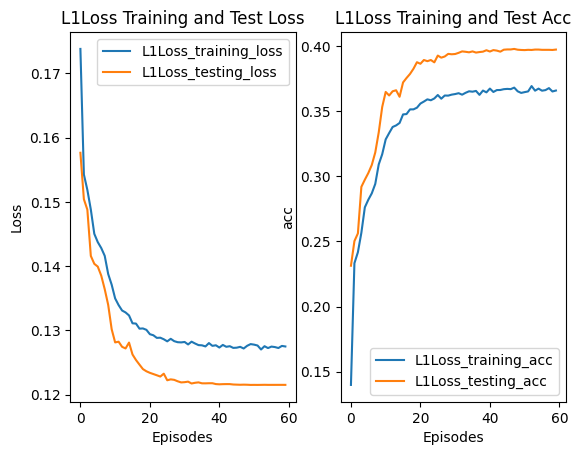

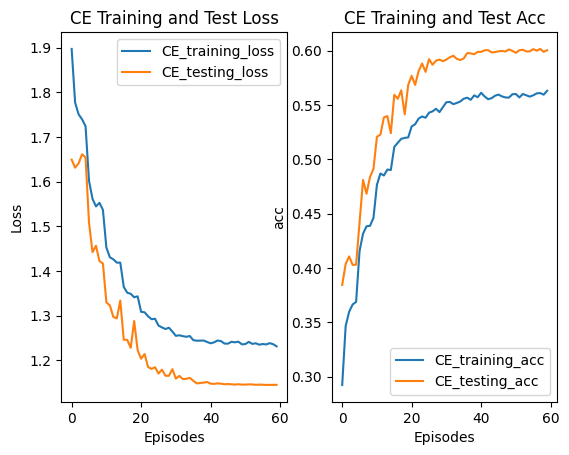

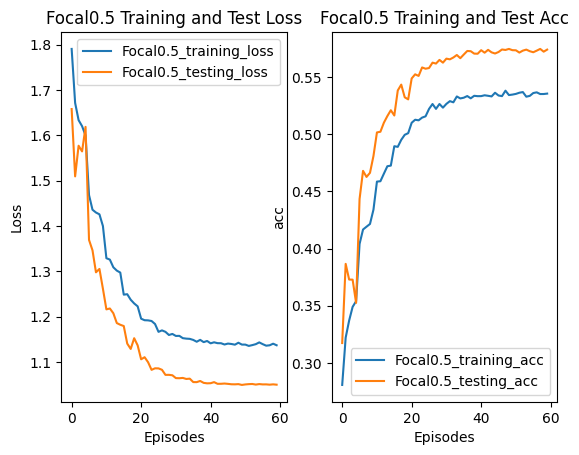

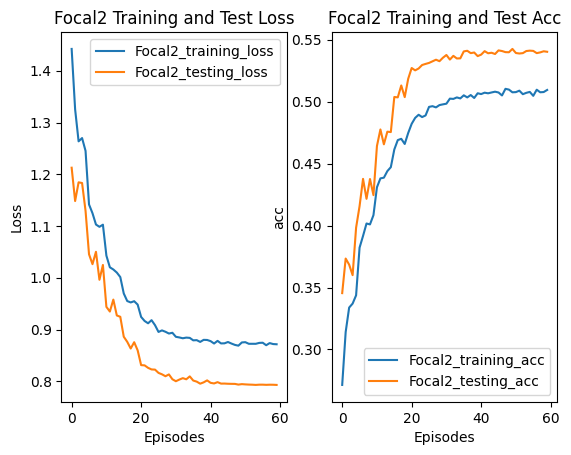

In [13]:
episodes_list = list(range(len(training_loss['Focal2'])))

labels = [f"{ltype}_training" for ltype in loss_type] + [f"{ltype}_testing" for ltype in loss_type]

for ltype in loss_type:
    # 创建一个新图形
    plt.subplot(1,2,1)
    plt.plot(episodes_list, training_loss[ltype], label=f"{ltype}_training_loss")
    plt.plot(episodes_list, testing_loss[ltype], label=f"{ltype}_testing_loss")
    plt.title(f'{ltype} Training and Test Loss')
    plt.xlabel('Episodes')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(episodes_list, training_acc[ltype], label=f"{ltype}_training_acc")
    plt.plot(episodes_list, testing_acc[ltype], label=f"{ltype}_testing_acc")
    plt.title(f'{ltype} Training and Test Acc')
    plt.xlabel('Episodes')
    plt.ylabel('acc')
    plt.legend()
    plt.show()
    


L1Loss


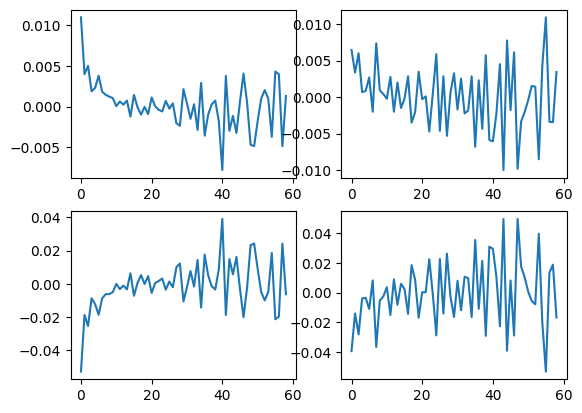

CE


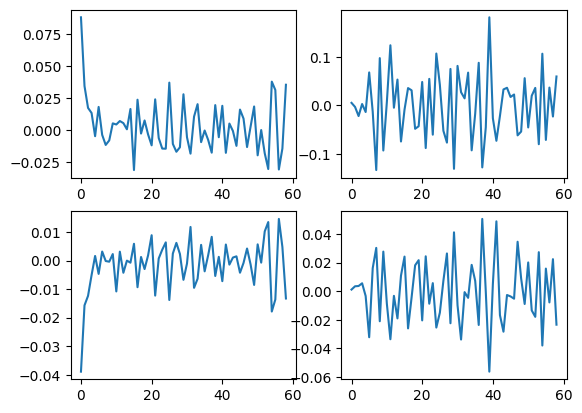

Focal0.5


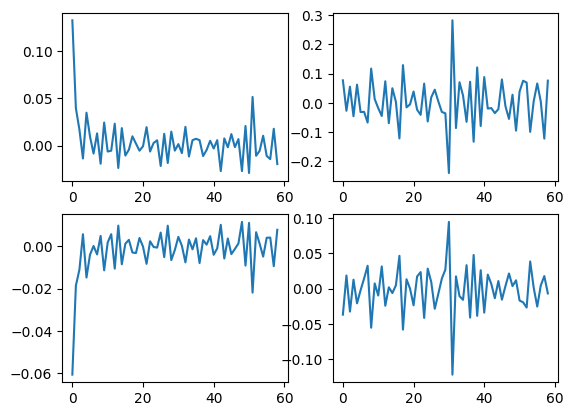

Focal2


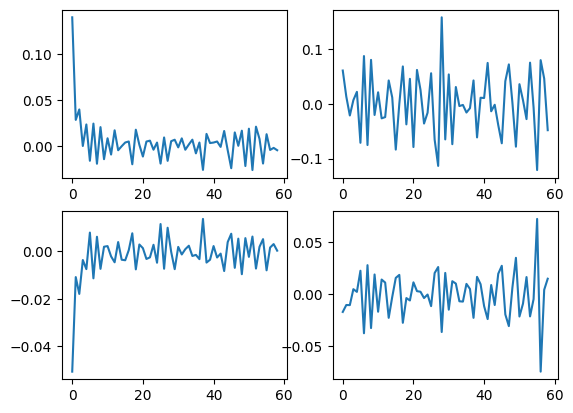

In [32]:
#do difference
def di(time_series):
    delta =[]
    for i in range(len(time_series)-1):
        delta.append(time_series[i]-time_series[i+1]) 
    return delta
episodes = list(range(len(training_loss['Focal2'])-1))
for ltype in loss_type:
    print(ltype)
    plt.subplot(2,2,1)
    plt.plot(episodes, di(training_loss[ltype]), label=f"{ltype}_training_loss")
    plt.subplot(2,2,2)
    plt.plot(episodes, di(testing_loss[ltype]), label=f"{ltype}_testing_loss")
    plt.subplot(2,2,3)
    plt.plot(episodes, di(training_acc[ltype]), label=f"{ltype}_training_acc")
    plt.subplot(2,2,4)
    plt.plot(episodes, di(testing_acc[ltype]), label=f"{ltype}_testing_acc")
    plt.show()
    

